In [1]:
import os

from   matplotlib import pyplot as plt
import numpy as np
from   PIL import Image
import tensorflow as tf
from   tensorflow.keras import regularizers
from   tensorflow.keras.callbacks import EarlyStopping
from   tensorflow.keras.datasets import cifar10
from   tensorflow.keras.layers import (
    Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, 
    MaxPooling2D)
from   tensorflow.keras.models import load_model, Sequential
from   tensorflow.keras.optimizers import RMSprop
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.utils import to_categorical

%matplotlib inline

In [2]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck']

In [3]:
BATCH = 32
N_CLASSES = 10
EPOCHS = 10
DECAY = 1e-4
DROPOUT = 0.2
ETA = 0.0001
SAVE_DIR = './saved_models'
MOD_NAME = 'cifar10_trained.h5'
N_IMG = 5

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [5]:
def show_imgs(imgs):
    plt.figure(1)
    img_idx = 0
    for i in range(N_IMG):
        for j in range(N_IMG):
            plt.subplot2grid((N_IMG, N_IMG), (i, j))
            plt.imshow(Image.fromarray(imgs[img_idx]))
            img_idx += 1
            plt.gca().axes.get_xaxis().set_visible(False)
            plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()

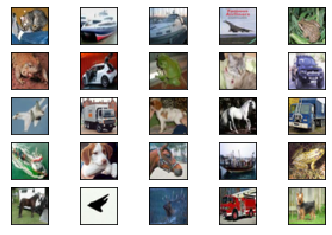

In [6]:
show_imgs(X_test[:N_IMG * N_IMG])

In [7]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [8]:
y_train = to_categorical(y_train, N_CLASSES)
y_test = to_categorical(y_test, N_CLASSES)

In [9]:
mod = Sequential()
mod.add(
    Conv2D(32, 
           (3, 3), 
           padding='same', 
           kernel_regularizer=regularizers.l2(DECAY), 
           input_shape=X_train.shape[1:]))
mod.add(Activation('elu'))
mod.add(BatchNormalization())
mod.add(
    Conv2D(32, 
           (3, 3), 
           padding='same', 
           kernel_regularizer=regularizers.l2(DECAY)))
mod.add(Activation('elu'))
mod.add(BatchNormalization())
mod.add(MaxPooling2D(pool_size=(2, 2)))
mod.add(Dropout(DROPOUT))

mod.add(
    Conv2D(64, 
           (3, 3), 
           padding='same', 
           kernel_regularizer=regularizers.l2(DECAY)))
mod.add(Activation('elu'))
mod.add(BatchNormalization())
mod.add(
    Conv2D(64, 
           (3, 3), 
           padding='same', 
           kernel_regularizer=regularizers.l2(DECAY)))
mod.add(Activation('elu'))
mod.add(BatchNormalization())
mod.add(MaxPooling2D(pool_size=(2, 2)))
mod.add(Dropout(1.5*DROPOUT))

mod.add(
    Conv2D(128, 
           (3, 3), 
           padding='same', 
           kernel_regularizer=regularizers.l2(DECAY)))
mod.add(Activation('elu'))
mod.add(BatchNormalization())
mod.add(
    Conv2D(128, 
           (3, 3), 
           padding='same', 
           kernel_regularizer=regularizers.l2(DECAY)))
mod.add(Activation('elu'))
mod.add(BatchNormalization())
mod.add(MaxPooling2D(pool_size=(2, 2)))
mod.add(Dropout(2*DROPOUT))

mod.add(Flatten())
mod.add(Dense(N_CLASSES, activation='softmax'))

In [10]:
opt = RMSprop(lr=ETA, decay=DECAY)

In [11]:
mod.compile(
    loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [12]:
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [13]:
# Real-time image preprocessing and augmentation
datagen = ImageDataGenerator(rotation_range=10, # degrees
                             width_shift_range=0.1, # fraction
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.1)

In [14]:
callback = EarlyStopping(monitor='accuracy', 
                         min_delta=0, 
                         patience=1, 
                         verbose=1, 
                         mode='max', 
                         restore_best_weights=True)

In [ ]:
mod.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH), 
                  epochs=EPOCHS, 
                  callbacks=[callback])

Epoch 1/10


In [ ]:
if not os.path.isdir(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    
mod_path = os.path.join(SAVE_DIR, MOD_NAME)
mod.save(mod_path)
print(f'Model saved at: {mod_path}')

In [ ]:
# Reload
mod1 = load_model(mod_path)
mod1.summary()

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_images(X_test[:N_IMG * N_IMG])
X_test = X_test.astype('float32') / 255

In [ ]:
indices = tf.argmax(input=mod1.predict(X_test[:N_IMG * N_IMG]), axis=1)
i = 0
print('Learned \t True')
print('=====================')
for index in indices:
    print(labels[index], '\t', labels[y_test[i][0]])
    i += 1